basically trying to figure out how $n(u)$ is computed in Appendix A.3 of 2201.07869 which follows Appendix C. of 1405.1452

this boils down to trying to parse https://github.com/philbull/RadioFisher and in particular     `RadioFisher/process_chime_baselines.py`
which relies on data files distributed at http://philbull.com/radiofisher_array_config.tar.gz

In [1]:
import numpy as np
import scipy.integrate
import astropy.units as u
import astropy.constants as cu

In [6]:
#table 2. of 2201.07869
Tsys = 55*u.K
Ssky = 31000 * u.deg**2

zcenter = 1.15
lmbda = 21*u.cm*(1+zcenter)
nu_center = cu.c / (lmbda)


ttot = 1*u.yr
Nant = 256
npol = 2
Ncyl = 4
wcyl = 20*u.m
lcyl = 78*u.m

SFOV = (90*u.deg * (lmbda/wcyl *(u.rad)))


eta = 0.7
Ae = eta * lcyl/Nant * wcyl

l4_over_Ae2 = ((lmbda/wcyl).si * u.rad)**2 * lmbda**2/(eta * lcyl / Nant)**2

nu_HI = cu.c / (21 * u.cm)

In [7]:
nu_center.to(u.MHz)

<Quantity 663.99215504 MHz>

In [8]:
Ddish = 20. #I believe thisis the same as cylinder width in 2201.07869
Dmin = 20.
Ndish = Nant * Ncyl

nu = nu_center.to(u.MHz).value # MHz
l = 3e8 / (nu * 1e6) # Lambda [m]

In [9]:
nu_center.to(u.MHz)

<Quantity 663.99215504 MHz>

In [21]:
# Cut baselines d < d_fov

nu_data = 800 #[MHz] they choose to tabulate at a different central nu but we're close enough
outfile = "data/nx_CHIME_%d.dat" % nu_data
AVG_SMALL_BASELINES = False
Dcut = Ddish # Cut baselines below this separation

In [22]:
(cu.c / u.MHz).si

<Quantity 299.792458 m>

In [23]:
3e8/1e6

300.0

In [24]:
def fov(nu, D):
    """
    Field of view, in rad^2, as a fn. of frequency.
    """
    l = 3e8 / (nu*1e6) #[length]
    #basically c/Mhz = 3e8/1e6 [meters]  ~ 300 Meters
    #so this converts nu to wavelength in units meters
    
    #l is lambda and then D is units meters
    
    #rayleigh criterion:
    #theta ~ 1.22 lambda/D
    #so theta = 1.22 l/d is units radians by definition
    #(pi/180)**2 converts from deg2 to radians2
    #I guess that implies that 180 * theta has units deg2
    #but that makes no sense unless 180 has units deg^2/rad
    #what the heck is 180 
    #the CHIME beam is 180 deg in one direction...
    #but this factor of 180 is also around in e.g. RadioFisher/process_tianlai_baselines.py
    
    #I guess maybe this doesnt matter, I never use this code but they do use it in
    #    RadioFisher/process_chime_baselines.py
    # and other codes...
    
    return 180. * 1.22 * (l/D) * (np.pi/180.)**2. 

def ubin_width(nu, D):
    """
    Bin width, corresponding to du at a given frequency (u = d / lambda).
    """
    return (1./30.) / np.sqrt(fov(nu, D)) # units 1/rad

#so I guess u has units 1/rad?

In [25]:
data = np.loadtxt(outfile)

In [26]:
x, n_x = data.T
_u = x * nu
nn = n_x / nu**2

In [27]:
norm = scipy.integrate.simps(2.*np.pi*nn*_u, _u)
print("n(u) renorm. factor:", 0.5 * Ndish * (Ndish - 1) / norm, "(not applied)")
nn_normalized = nn * 0.5 * Ndish * (Ndish - 1) / norm

n(u) renorm. factor: 0.7041507993199257 (not applied)


/tmp/ipykernel_184743/1923997928.py:1: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm = scipy.integrate.simps(2.*np.pi*nn*_u, _u)


In [52]:
idxs = np.where(nn_normalized > 0)
fid_n_u = np.median(nn_normalized[idxs]) * u.rad**2 #I think that n_u should be rad^2 bc u is units 1/rad
# fid_n_u = np.min(nn_normalized[idxs]) * u.rad**2 #I think that n_u should be rad^2 bc u is units 1/rad

In [53]:

#as density increases, noise decreases

Text(0, 0.5, 'n(u) [sr]')

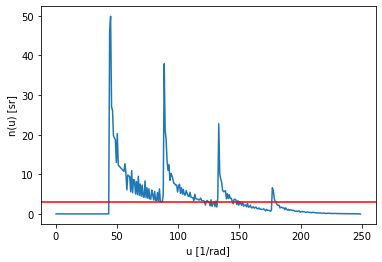

In [54]:
import matplotlib.pyplot as plt
plt.plot(_u, nn_normalized)
plt.axhline(fid_n_u.value, c='r')
plt.xlabel('u [1/rad]')
plt.ylabel('n(u) [sr]')

based on Eq.(6) of 1405.1452, e.g.
$$n(u) = \frac{N_d(N_d-1)}{2\pi (u_{\rm max}^2 - u_{\rm min}^2)} $$
where $u_{\rm max}=D_{\rm max} /\lambda$ and $u_{\rm min}= D_{\rm min} / \lambda$ and the $D_{\dots}$ are the lenghts of the longest/shortest baselines, I believe that $n(u)$ is either dimensionless or has units per sterradian or something. 

From Eq. (A9) 2201.07869 and assuming that $n(u)$ is a constant set to its mean value we have
$$C^N(z) = \frac{T_{\rm sys}^2}{\nu_{21}n_{\rm pol} t_{\rm tot} }\frac{\lambda^4 S_{\rm sky}}{A_e^2 S_{\rm FOV}}\frac 1 {n_{\rm fid}}$$
This is also Eq. (D2) of Bull+14

A key question is what the heck the units of everything is. It seems like $\sigma_S$ is $\sigma_T$ but converted with rayleigh jeans and a little more. To me it looks like the units of $\sigma_T$ is units kelvin per sterradian (see DERIVATION OF NOISE EXPRESSIONS of Bull+14). This can then be put back into Jy/sr with another rayleigh jeans

Now because $P_N = \sigma_T^2 V_{\rm pix}$ it seems like $P_N$ has units $({\rm Jy/sr})^2 {\rm Mpc}^3$. From there we have (above Eq. (D1)) that $C^N = P_N / (r^2r_\nu)$ meaning it looks like the $C^N$ we are computing should have units $({\rm Jy/sr})^2$

for everything we pull values from Table. 2 of 2201.07869

In [55]:
(cu.c / (lmbda * (1+zcenter)))

<Quantity 3088335.60483144 m / (cm s)>

In [56]:
u.Jy.si

Unit("1e-26 kg / s2")

In [57]:
noise_power = Tsys**2 / (nu_HI * npol * ttot) * Ssky/(SFOV) * l4_over_Ae2 * 1/fid_n_u

In [58]:
noise_power.si

<Quantity 6.88971304e-15 K2>

In [59]:
noise_sigma = (2. * nu_center**2 * cu.k_B
               * np.sqrt(noise_power)
               / cu.c**2) / u.sr

In [60]:
CN = (noise_sigma**2).to(u.kJy**2/u.sr**2)

In [61]:
CN

<Quantity 1.26414436e-12 kJy2 / sr2>

now we need to get to the 3D nosie spectrum. In the "Interferometer (cross-correlation)" section of App. "DERIVATION OF NOISE EXPRESSIONS" we have
$$\textrm{3D Noise Power}= r^2 r_\nu C^N $$
Where I believe $r$ is the comoving distance to some freq/redshift. 
I will take $r$ to be the comoving distance to the central redshift. 
This appears because $\vec r_\perp = r \vec \theta$.
$r_\nu$ is something related to comoving depth. From `RadioFisher/plotting/plot_Veff.py` it's computed as 

`rnu = C*(1.+z)**2. / H(z)`

where `C = 3e5 # Speed of light, km/s`

In [62]:
from LIMxCMBL.init import *

In [63]:
rnu = (cu.c * (1+zcenter)**2 / (cosmo['h']*(100*(u.km/u.s/u.Mpc))*ccl.background.h_over_h0(cosmo, 1./(zcenter+1)))).to(u.Mpc)

In [64]:
CN * rnu * (ccl.comoving_radial_distance(cosmo, 1/(1+zcenter))**2 * u.Mpc**2)

<Quantity 0.18873682 kJy2 Mpc3 / sr2>